In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time
import tensorflow as tf 
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data = data.dropna()  
    return data

def prepare_features_and_labels(data):
    features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
    target = 'class'
    X = data[features].values
    y = data[target].values
    return X, y

def balance_and_sample(X, y, sample_fraction=0.4):
    X, y = shuffle(X, y, random_state=42)
    sample_size = int(sample_fraction * len(X))
    X_sample, y_sample = X[:sample_size], y[:sample_size]
    
    classes = np.unique(y_sample)
    max_samples = max([np.sum(y_sample == cls) for cls in classes])
    
    X_balanced = []
    y_balanced = []
    
    for cls in classes:
        X_cls = X_sample[y_sample == cls]
        y_cls = y_sample[y_sample == cls]
        
        X_balanced.append(X_cls[:max_samples])
        y_balanced.append(y_cls[:max_samples])
    
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.hstack(y_balanced)
    
    return X_balanced, y_balanced

def preprocess_data(data):
    if 'timestamp' not in data.columns or 'class' not in data.columns:
        raise ValueError("Data must contain 'timestamp' and 'class' columns.")
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['timestamp'])
    data['month'] = data['timestamp'].dt.to_period('M')
    months = data['month'].astype(str).unique()
    
    if len(months) < 4:
        raise ValueError("Not enough distinct months to split into global and client data.")
    
    months.sort()
    first_two_months = months[:2]
    last_two_months = months[-2:]
    
    global_data = data[data['month'].astype(str).isin(first_two_months)]
    client1_data = data[data['month'].astype(str) == last_two_months[0]]
    client2_data = data[data['month'].astype(str) == last_two_months[1]]
    
    if global_data.empty or client1_data.empty or client2_data.empty:
        raise ValueError("One or more of the filtered datasets are empty.")
    
    return global_data, client1_data, client2_data

def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = GRU(32)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def measure_communication_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def federated_learning(global_data, client1_data, client2_data):
    print("Preparing global data...")
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    
    print("Preparing client data...")
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    
    X_global = X_global[:, np.newaxis, :]
    X_client1 = X_client1[:, np.newaxis, :]
    X_client2 = X_client2[:, np.newaxis, :]
    
    print("Creating and training global model...")
    model = create_gru_model(input_shape=(X_global.shape[1], X_global.shape[2]))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=2)
    print(f"Time to train global model: {train_time_global:.2f} seconds.")
    
    client_data = [
        (X_client1, y_client1, "Client 1"),
        (X_client2, y_client2, "Client 2")
    ]
    
    print("Fine-tuning model on client data...")
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        print(f"Fine-tuning on {client_name}...")
        
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=2)
        
        _, update_time = measure_communication_time(train_func)
        print(f"Time to fine-tune on {client_name}: {update_time:.2f} seconds.")
    
    print("Evaluating the updated global model...")
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    print("Model Classification Report:")
    print(classification_report(y_global, y_global_pred))
    print("Model Accuracy Score:", accuracy_score(y_global, y_global_pred))
    
    print("Federated learning completed.")
    return train_time_global, update_time

file_path = 'Metro-Both-Classes.csv'
data = load_and_preprocess_data(file_path)
global_data, client1_data, client2_data = preprocess_data(data)
train_time_global_no_compression, update_time_no_compression = federated_learning(global_data, client1_data, client2_data)


Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 16s - 3ms/step - accuracy: 0.9731 - loss: 0.0544
Epoch 2/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9832 - loss: 0.0367
Epoch 3/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9898 - loss: 0.0268
Epoch 4/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9912 - loss: 0.0245
Epoch 5/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9929 - loss: 0.0207
Epoch 6/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9937 - loss: 0.0195
Epoch 7/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9935 - loss: 0.0191
Epoch 8/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9941 - loss: 0.0183
Epoch 9/10
5145/5145 - 12s - 2ms/step - accuracy: 0.9944 - loss: 0.0178
Epoch 10/10
5145/5145 - 11s - 2ms/step - accuracy: 0.9947 - loss: 0.0172
Time to train global model: 114.72 seconds.
Fine-tuning model on client data...


Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1...
Epoch 1/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9968 - loss: 0.0110
Epoch 2/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9975 - loss: 0.0071
Epoch 3/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9975 - loss: 0.0071
Epoch 4/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9976 - loss: 0.0062
Epoch 5/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9975 - loss: 0.0064


Clients:  50%|█████     | 1/2 [00:28<00:28, 28.94s/client]

Time to fine-tune on Client 1: 28.94 seconds.
Fine-tuning on Client 2...
Epoch 1/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9965 - loss: 0.0110
Epoch 2/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9982 - loss: 0.0062
Epoch 3/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9986 - loss: 0.0056
Epoch 4/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9987 - loss: 0.0051
Epoch 5/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9987 - loss: 0.0050


Clients: 100%|██████████| 2/2 [00:59<00:00, 29.72s/client]

Time to fine-tune on Client 2: 30.50 seconds.
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    160227
           1       0.00      0.00      0.00      4386

    accuracy                           0.97    164613
   macro avg       0.49      0.50      0.49    164613
weighted avg       0.95      0.97      0.96    164613

Model Accuracy Score: 0.9733435390886503
Federated learning completed.


In [9]:
def compress_gradients_sparsification(gradients, threshold=0.1):
    compressed_gradients = []
    for grad in gradients:
        mask = tf.abs(grad) > threshold
        compressed_gradients.append(tf.multiply(grad, tf.cast(mask, grad.dtype)))
    return compressed_gradients

def federated_learning_with_compression(global_data, client1_data, client2_data):
    print("Preparing global data...")
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    
    print("Preparing client data...")
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    
    X_global = X_global[:, np.newaxis, :]
    X_client1 = X_client1[:, np.newaxis, :]
    X_client2 = X_client2[:, np.newaxis, :]
    
    print("Creating and training global model...")
    model = create_gru_model(input_shape=(X_global.shape[1], X_global.shape[2]))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=2)
    print(f"Time to train global model: {train_time_global:.2f} seconds.")
    
    client_data = [
        (X_client1, y_client1, "Client 1"),
        (X_client2, y_client2, "Client 2")
    ]
    
    print("Fine-tuning model on client data with gradient compression...")
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        print(f"Fine-tuning on {client_name} with gradient compression...")
        
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=2)
        
        _, update_time = measure_communication_time(train_func)
        print(f"Time to fine-tune on {client_name}: {update_time:.2f} seconds.")
        
        with tf.GradientTape() as tape:
            logits = model(X_client, training=True)
            y_client = tf.reshape(y_client, (-1, 1))
            loss = tf.keras.losses.binary_crossentropy(y_client, logits)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        compressed_gradients = compress_gradients_sparsification(gradients)
        print(f"Compressed gradients size for {client_name}: {sum([tf.size(g).numpy() for g in compressed_gradients])}")
        
        model.optimizer.apply_gradients(zip(compressed_gradients, model.trainable_variables))
    
    print("Evaluating the updated global model...")
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    print("Model Classification Report:")
    print(classification_report(y_global, y_global_pred))
    print("Model Accuracy Score:", accuracy_score(y_global, y_global_pred))
    
    print("Federated learning with gradient compression completed.")
    return train_time_global, update_time

train_time_global_compression, update_time_compression = federated_learning_with_compression(global_data, client1_data, client2_data)


Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9730 - loss: 0.0551
Epoch 2/10
5145/5145 - 13s - 3ms/step - accuracy: 0.9788 - loss: 0.0425
Epoch 3/10
5145/5145 - 14s - 3ms/step - accuracy: 0.9887 - loss: 0.0286
Epoch 4/10
5145/5145 - 13s - 3ms/step - accuracy: 0.9906 - loss: 0.0251
Epoch 5/10
5145/5145 - 13s - 3ms/step - accuracy: 0.9919 - loss: 0.0223
Epoch 6/10
5145/5145 - 13s - 3ms/step - accuracy: 0.9930 - loss: 0.0205
Epoch 7/10
5145/5145 - 14s - 3ms/step - accuracy: 0.9932 - loss: 0.0197
Epoch 8/10
5145/5145 - 13s - 3ms/step - accuracy: 0.9932 - loss: 0.0203
Epoch 9/10
5145/5145 - 16s - 3ms/step - accuracy: 0.9945 - loss: 0.0174
Epoch 10/10
5145/5145 - 17s - 3ms/step - accuracy: 0.9944 - loss: 0.0176
Time to train global model: 143.64 seconds.
Fine-tuning model on client data with gradient compression...


Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1 with gradient compression...
Epoch 1/5
2707/2707 - 7s - 3ms/step - accuracy: 0.9973 - loss: 0.0094
Epoch 2/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9981 - loss: 0.0056
Epoch 3/5
2707/2707 - 7s - 3ms/step - accuracy: 0.9985 - loss: 0.0051
Epoch 4/5
2707/2707 - 7s - 3ms/step - accuracy: 0.9984 - loss: 0.0053
Epoch 5/5
2707/2707 - 6s - 2ms/step - accuracy: 0.9986 - loss: 0.0050
Time to fine-tune on Client 1: 36.78 seconds.


Clients:  50%|█████     | 1/2 [00:37<00:37, 37.66s/client]

Compressed gradients size for Client 1: 25509
Fine-tuning on Client 2 with gradient compression...
Epoch 1/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9962 - loss: 0.0121
Epoch 2/5
2783/2783 - 11s - 4ms/step - accuracy: 0.9981 - loss: 0.0067
Epoch 3/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9983 - loss: 0.0061
Epoch 4/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9981 - loss: 0.0061
Epoch 5/5
2783/2783 - 6s - 2ms/step - accuracy: 0.9983 - loss: 0.0057
Time to fine-tune on Client 2: 39.61 seconds.


Clients: 100%|██████████| 2/2 [01:17<00:00, 38.97s/client]

Compressed gradients size for Client 2: 25509
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    160227
           1       0.00      0.00      0.00      4386

    accuracy                           0.97    164613
   macro avg       0.49      0.50      0.49    164613
weighted avg       0.95      0.97      0.96    164613

Model Accuracy Score: 0.9733556887973611
Federated learning with gradient compression completed.


c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


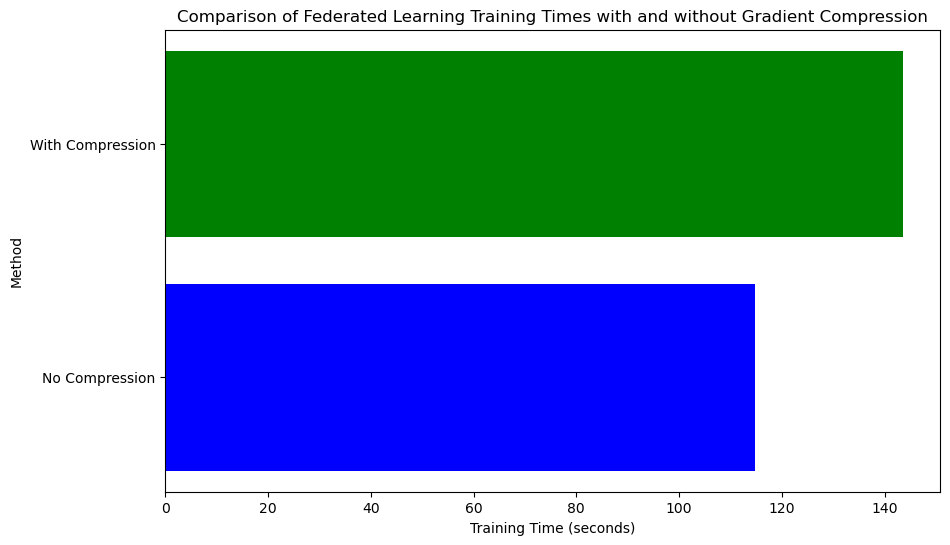

In [10]:
methods = ["No Compression", "With Compression"]
train_times = [train_time_global_no_compression, train_time_global_compression]
update_times = [update_time_no_compression, update_time_compression]

plt.figure(figsize=(10, 6))
plt.barh(methods, train_times, color=['blue', 'green'])
plt.xlabel("Training Time (seconds)")
plt.ylabel("Method")
plt.title("Comparison of Federated Learning Training Times with and without Gradient Compression")
plt.show()

